In [1]:
import pandas as pd
import numpy as np
import itertools
from pprint import pprint
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

In [2]:
Q = 1.0
T = 1.0

class Game(object):
    def __init__(self,df):
        self.df = df                                  #df = dataframe
        self.df_capability = df.Capability.to_dict()    
        self.df_position = df.Position.to_dict()    
        self.df_salience = df.Salience.to_dict()    
        self.max_pos = df.Position.max()
        self.min_pos = df.Position.min()

    def weighted_median(self):                                       # Median Voter Calculation
        self.df['w'] = self.df.Capability*self.df.Salience           # power 
        self.df['w'] = self.df['w'] / self.df['w'].sum()
        self.df['w'] = self.df['w'].cumsum()
        return float(self.df[self.df['w']>=0.5].head(1).Position)

    def mean(self):
        return (self.df.Capability*self.df.Position*self.df.Salience).sum() / \
               (self.df.Capability*self.df.Salience).sum()

    # utility of success
    def Usi_i(self,i,j,ri=1.):
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 2. - 4.0 * ( (0.5-0.5*np.abs(float(tmp1)/tmp2) )**ri)

    # utility of failure
    def Ufi_i(self,i,j,ri=1.):
        tmp1 = self.df_position[i]-self.df_position[j]
        tmp2 = self.df.Position.max()-self.df.Position.min()
        return 2. - 4.0 * ( (0.5+0.5*np.abs(float(tmp1)/tmp2) )**ri )

    # utility of status-quo
    def Usq_i(self,i,ri=1.):
        return 2.-(4.*(0.5**ri))

    def Ui_ij(self,i,j):
        tmp1 = self.df_position[i] - self.df_position[j]
        tmp2 = self.max_pos-self.min_pos
        return 1. - 2.*np.abs(float(tmp1) / tmp2) 

    def v(self,i,j,k):
        return self.df_capability[i]*self.df_salience[i]*(self.Ui_ij(i,j)-self.Ui_ij(i,k)) 

    def Pi(self,i):
        l = np.array([[i,j,k] for (j,k) in itertools.combinations(range(len(self.df)), 2 ) if i!=j and i!=k])
        U_filter = [self.Ui_ij(j,i)>self.Ui_ij(i,k) for i, j, k in l]
        lpos = l[U_filter]
        tmp1 = np.sum([self.v(j,i,k) for i, j, k in lpos])
        tmp2 = np.sum([self.v(j,i,k) for i, j, k in l])
        return float(tmp1)/tmp2

    # utility of changing for better
    def Ubi_i(self,i,j,ri=1):
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 - (0.25 * float(tmp1) / tmp2))**ri)

    # utility of changing for worse
    def Uwi_i(self,i,j,ri=1):
        tmp1 = np.abs(self.df_position[i] - self.weighted_median()) + \
               np.abs(self.df_position[i] - self.df_position[j])
        tmp2 = np.abs(self.max_pos-self.min_pos)
        return 2. - (4. * (0.5 + (0.25 * float(tmp1) / tmp2))**ri)

    def EU_i(self,i,j,r=1):
        term1 = self.df_salience[j] * \
                ( self.Pi(i)*self.Usi_i(i,j,r) + ( 1.-self.Pi(i) )*self.Ufi_i(i,j,r) )
        term2 = (1-self.df_salience[j])*self.Usi_i(i,j,r)
        term3 = -Q*self.Usq_i(i,r)
        term4 = -(1.-Q)*( T*self.Ubi_i(i,j,r) + (1.-T)*self.Uwi_i(i,j,r) )
        return term1+term2+term3+term4

    def EU_j(self,i,j,r=1):
        return self.EU_i(j,i,r)

    def Ri(self,i):
        # get all j's except i
        l = [x for x in range(len(self.df)) if x!= i]
        #tmp = np.array(list(map(lambda x: self.EU_j(i,x), l)))
        tmp = np.array([self.EU_j(i,x) for x in l])
        numterm1 = 2 * np.sum(tmp)
        numterm2 = (len(self.df)-1)*np.max(tmp)
        numterm3 = (len(self.df)-1)*np.min(tmp)
        return float(numterm1-numterm2-numterm3) / (numterm2-numterm3)

    def ri(self,i):
        Ri_tmp = self.Ri(i)
        return (1-Ri_tmp/3.) / (1+Ri_tmp/3.)

    def Qij(self,i,j):
        l = np.array([k for k in range(len(self.df))])
        res = map(lambda x: self.Pi(k)+(1-self.df_salience[k]),l)
        return np.product(res)

    def do_round(self,df):
        self.df = df
        df_new = self.df.copy()        
        # reinit
        self.df_capability = self.df.Capability.to_dict()    
        self.df_position = self.df.Position.to_dict()    
        self.df_salience = self.df.Salience.to_dict()    
        self.max_pos = self.df.Position.max()
        self.min_pos = self.df.Position.min()

        #offers = [list() for i in range(len(self.df))]
        offers = pd.DataFrame(columns=self.df.Actor, index=self.df.Actor)
        EU = pd.DataFrame(columns=self.df.Actor, index=self.df.Actor)
        ris = [self.ri(i) for i in range(len(self.df))]
        for (i,j) in itertools.combinations(range(len(self.df)), 2 ):           # combinations('ABCD', 2) --> AB AC AD BC BD CD
            eui = self.EU_i(i,j,r=ris[i])
            euj = self.EU_j(i,j,r=ris[j])
            EU.set_value(i, j, eui, True)
            EU.set_value(j, i, euj, True)
            if eui > 0 and euj > 0:
                # conflict
                mid_step = (self.df_position[i]-self.df_position[j])/2.
                #print(i,j,eui,euj,'conflict, both step', mid_step, -mid_step)
                offers.set_value(j,i,mid_step,True)
                offers.set_value(i,j,-mid_step,True)
                #offers[j].append(mid_step)
                #offers[i].append(-mid_step)
            elif eui > 0 and euj < 0 and np.abs(eui) > np.abs(euj):
                # compromise - actor i has the upper hand
                #print(i,j,eui,euj,'compromise', i, 'upper hand')
                xhat = (self.df_position[i]-self.df_position[j]) * np.abs(euj/eui)
                #offers[j].append(xhat)
                offers.set_value(j,i,xhat,True)
            elif eui < 0 and euj > 0 and np.abs(eui) < np.abs(euj):
                # compromise - actor j has the upper hand
                #print(i,j,eui,euj,'compromise', j, 'upper hand')
                xhat = (self.df_position[j]-self.df_position[i]) * np.abs(eui/euj)
                #offers[i].append(xhat)
                offers.set_value(i,j,xhat,True)
            elif eui > 0 and euj < 0 and np.abs(eui) < np.abs(euj):
                # capinulation - actor i has upper hand
                j_moves = self.df_position[i]-self.df_position[j]
                #print(i,j,eui,euj,'capitulate', i, 'wins', j, 'moves',j_moves)
                #offers[j].append(j_moves)
                offers.set_value(j,i,j_moves,True)
            elif eui < 0 and euj > 0 and np.abs(eui) > np.abs(euj):
                # capitulation - actor j has upper hand
                i_moves = self.df_position[j]-self.df_position[i]
                #print(i,j,eui,euj,'capitulate', j, 'wins', i, 'moves',i_moves)
                #offers[i].append(i_moves)
                offers.set_value(i,j,i_moves,True)
            #else:
                #print(i,j,eui,euj,'nothing')
        
        best_offer = offers.abs().min(axis=1).fillna(0)
        
        print('\nData Frame:\n')
        print(self.df)
        print('=================\nExpected Utility:\n')
        print(EU)
        print('=================\nOffers:\n')
        print(offers)
        print('=================\nBest offer:\n')
        print(best_offer)
        df_new['offer'] = best_offer.as_matrix()
        df_new['Position'] = df_new['Position'] + df_new.offer
        df_new.loc[df_new['Position']>self.max_pos,'Position'] = self.max_pos
        df_new.loc[df_new['Position']<self.min_pos,'Position'] = self.min_pos
        return df_new


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#df = pd.read_csv('actors.csv', sep=',')
df = pd.read_excel('Pelda.xlsx', 'Pelda1')
df.Position = df.Position.astype(float)
df.Capability = df.Capability.astype(float)
df.Salience = df.Salience.astype(float)
df.head()

,Actor,Capability,Position,Salience
0,A,100.0,100.0,1.0
1,B,100.0,90.0,1.0
2,C,50.0,50.0,0.5
3,D,5.0,5.0,0.1
4,E,10.0,10.0,0.2


In [5]:
game = Game(df)

results = pd.DataFrame(index=df.index)
for i in range(20):
    print('=================================================')
    print('Round', i+1)
    print('=================================================')
    results[i] = df.Position
    df = game.do_round(df)
    print(df)
    print('\nweighted_median', game.weighted_median(), 'mean', game.mean())

results =  results.T
results.columns = df.Actor
print(results)

Round 1

Data Frame:

  Actor  Capability  Position  Salience         w
0     A       100.0     100.0       1.0  0.439560
1     B       100.0      90.0       1.0  0.879121
2     C        50.0      50.0       0.5  0.989011
3     D         5.0       5.0       0.1  0.991209
4     E        10.0      10.0       0.2  1.000000
Expected Utility:

Actor         A         B          C          D          E
Actor                                                     
A           NaN  0.214778    1.05186    1.91056    1.82895
B       0.21431       NaN   0.845301    1.74066    1.64699
C     -0.348304 -0.275472        NaN   0.820764   0.619809
D      -1.87441  -1.68193  0.0200113        NaN  0.0614649
E      -1.81434  -1.61606  0.0110107  0.0826493        NaN
Offers:

Actor        A        B     C     D    E
Actor                                   
A          NaN       -5   NaN   NaN  NaN
B            5      NaN   NaN   NaN  NaN
C      16.5566  13.0354   NaN -22.5  -20
D      93.2025  82.1319  22.5   

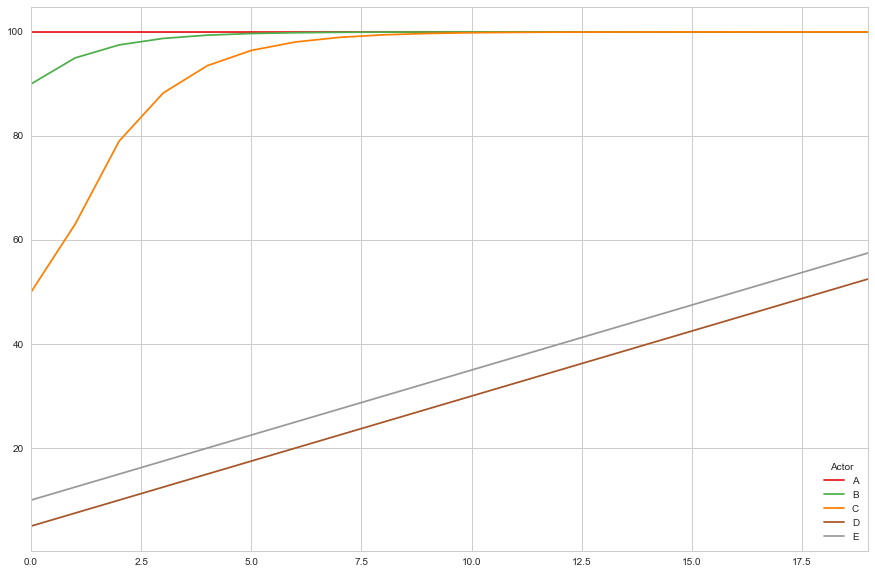

In [6]:
plt.style.use('seaborn-whitegrid')
results.plot(figsize=(15,10), colormap='Set1')